# Algorytm Genetyczny

## Tydzień 3. -  Optymalizacja wag w sieci MLP z użyciem algorytmu genetycznego



Zaimplementować proste uczenie MLP z użyciem algorytmu genetycznego. Na wejściu jest: struktura sieci neuronowej i dane uczące. Optymalizowana funkcja to funkcja przekształcająca wektor wag sieci na błąd na zbiorze uczącym. Zastosować standardowe operatory krzyżowania i mutacji.

Przeprowadzić uczenie na zbiorach:

    iris https://archive.ics.uci.edu/ml/datasets/Iris
    multimodal-large (z części laboratorium o sieciach neuronowych)
    auto-mpg (przewidzieć wartość mpg) - http://archive.ics.uci.edu/ml/datasets/Auto+MPG



In [1]:
import numpy as np
from random import sample
import math
from bisect import bisect
import random
from IPython.display import Image
from IPython.core.display import HTML 
from numpy import genfromtxt
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from matplotlib import pyplot as plt

In [137]:
class genetic:
    def __init__(self,function_, n_variables, population_size):
        self.function_ = function_
        self.n_variables = n_variables
        self.population_size = population_size
        self.population = [np.random.uniform(-1, 1, size=[n_variables]) for i in range(population_size)]
    
    def iteration(self):
        p = np.random.permutation(self.population_size)[0:math.floor(self.population_size*0.2)]
        mutated = genetic.mutate([self.population[i] for i in p])
        p = np.random.permutation(self.population_size)[0:math.floor(self.population_size*0.7)]
        children = genetic.crossover([self.population[i] for i in p])
        whole_population = children + mutated + self.population
        values = np.array(list(map(self.function_,whole_population)))
        probs = np.cumsum(values/sum(values))
        survivors = [bisect(probs,el) for el in np.random.uniform(0,1,self.population_size)]
        self.population = [whole_population[i] for i in survivors]
    
    def iterate(self,iterations):
        for it in range(iterations):
            self.iteration()
            
    def optimum(self):
        values = np.array(list(map(self.function_,self.population)))
        return np.array(self.population)[values == max(values)][0]
    
    @staticmethod
    def mutation(element_):
        return element_ + np.random.normal(0,2,len(element_))
        
    @staticmethod
    def mutate(population_):
        return [genetic.mutation(el) for el in population_]
    
    @staticmethod
    def cross(element1, element2):
        i = random.randint(0, len(element1)-1)
        element1_ = np.concatenate((element1[0:i],element2[i:]))
        element2_ = np.concatenate((element2[0:i],element1[i:]))
        return [np.array(element1_), np.array(element2_)]
    
    @staticmethod
    def crossover(population_):
        crossed = [genetic.cross(population_[i],population_[i+1]) for i in range(0,len(population_)-1,2)]
        crossed = sum(crossed, [0,0])[2:]
        return crossed
    
    

In [3]:
class MLP:
    """
    layers - wektor zawierający liczbę kolejnych neuronów warstwach, w tym wejscie i wyjscie
    weights_biases - wybor metody losowania wag
    activation_function - funkcja aktywacji
    activation_function_der - pochodna funkcja aktywacji
    delta_w, delta_b - zmiana biasu i wag w propagacji wstecznej
    softmax_metod - zastosowanie softmax na ostatniej warstwie
    """
    
    
    def __init__(self, layers, weights_biases, activation_function, softmax_method = False, regularization = "none"):
        self.layers = layers
        self.softmax_method = softmax_method
        self.weights = []
        self.biases = []
        self.delta_w = []
        self.delta_b = []
        
        if activation_function == "sigmoid":
            self.activation_function = self.sigmoid
            self.activation_function_der = self.sigmoid_der
        elif activation_function == "linear":
            self.activation_function = self.linear
            self.activation_function_der = self.linear_der
        elif activation_function == "tanh":
            self.activation_function = self.tanh
            self.activation_function_der = self.tanh_der
        elif activation_function == "relu":
            self.activation_function = self.relu
            self.activation_function_der = self.relu_der

        if weights_biases == "Random":
            self.weights_random()
        elif weights_biases == "Xavier": 
            self.weights_xavier()
        
    def weights_random(self):
        """
        losowanie wag z rozkladu jednostajnego z przedzialu [-1,1] 
        """
        for i in range(len(self.layers) - 1):
            self.weights.append(np.random.uniform(
                -1, 1, self.layers[i] * self.layers[i + 1]).reshape(layers[i], self.layers[i + 1]))
            self.biases.append(np.random.uniform(-1, 1, self.layers[i + 1]).reshape(1, self.layers[i+1]))
            
    def weights_xavier(self):
        """
        losowanie wag metodą Xaviera
        """
        xavier = np.sqrt(6)/np.sqrt(self.layers[1]+self.layers[-1])
        for i in range(len(self.layers) - 1):
            self.weights.append(xavier * np.random.uniform(
                -1, 1, self.layers[i] * self.layers[i + 1]).reshape(layers[i], self.layers[i + 1]))
            self.biases.append(xavier * np.random.uniform(-1, 1, self.layers[i + 1]).reshape(1, self.layers[i+1]))

    
    def forward(self, inputs):
        """
        przejscie do przodu po sieci 
        """
        self.A = []
        self.z = []

        a = inputs
        self.A.append(a)
        for i in range(len(self.layers)-2):

            outputs = a @ self.weights[i] + self.biases[i]
            self.z.append(outputs)
            a = self.activation_function(outputs)
            self.A.append(a)
        results = a @ self.weights[-1] + self.biases[-1]
        if self.softmax_method:
            results = self.softmax(results)
        self.z.append(results)
        self.A.append(results)
        return results

 
    def classify(self,x):
        probability = self.forward(x)
        return [i.argmax() for i in probability]
    
    
    @staticmethod
    def sigmoid(x):
        z = np.array(x)
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def sigmoid_der(x):
        return MLP.sigmoid(x) * (1 - MLP.sigmoid(x))
    
    @staticmethod
    def softmax(x):
        e_x = np.exp(x.T - np.max(x, axis=1).T).T
        return (e_x.T / e_x.sum(axis=1).T).T
    
    @staticmethod
    def linear(x):
        return np.array(x)
    
    @staticmethod
    def linear_der(x):
        return np.ones(x.shape)
    
    @staticmethod
    def tanh(x):
        return np.tanh(x)
    
    @staticmethod
    def tanh_der(x):
        return 1/np.cosh(x)**2
    
    @staticmethod
    def relu(x):
        z = np.array(x)    
        return np.maximum(0,z)
    
    @staticmethod
    def relu_der(x):
        z = np.array(x)    
        z[z<0]=0
        z[z!=0] = 1
        return z


Korzystam z mojej klasy MLP, którą napisałem przy okazji pierwszej części laboratoriów.

## Zbiór 1.

W MLP wagi przechowywane są w postaci listy macierzy, poniższa funkcja zamienia wektor używany w klasie *genetic* na listę macierzy, które są wagami MLP.

In [4]:
def vector_to_weights(vector_,layers):
    matrices_ = [layers[i]*layers[i+1] for i in range(len(layers)-1)]
    matrices_.insert(0,0)
    matrices_cs = np.cumsum(matrices_)
    weights = [vector_[matrices_cs[i]:matrices_cs[i+1]].reshape(layers[i], layers[i+1]) for i in range(len(matrices_cs)-1)]
    return weights

Funkcja licząca *accuracy* na zbiorze, tę funkcję optymalizuje (szukam jej maksimum)

In [147]:
def mlp_score(v):
    vec = np.array(v)
    mlp.weights = vector_to_weights(vec, layers)
    return accuracy_score(labels, mlp.classify(df))

In [148]:
df = datasets.load_iris()['data']
labels = datasets.load_iris()['target']

In [149]:
layers = [4,10,12,3]
matrices = [layers[i]*layers[i+1] for i in range(len(layers)-1)]
mlp = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = True)

In [150]:
gen = genetic(mlp_score, sum(matrices), 100)
results = []
x_axis = []
for i in range(100):
    mlp.weights = vector_to_weights(gen.optimum(),layers)
    results.append(accuracy_score(labels, mlp.classify(df)))
    x_axis.append(i)
    gen.iterate(1)

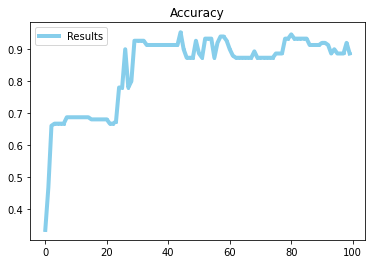

In [151]:
df=pd.DataFrame({'x_values': x_axis, 'Results': results})
plt.plot( 'x_values', 'Results', data=df, marker='o', markerfacecolor='skyblue', markersize=2, color='skyblue', linewidth=4)
plt.title("Accuracy")
plt.legend()

Widać, że algorytm genetyczny dobrze poradził sobie tym zbiorem. Funkcja nie jest śliśle rosnąca, jednak musimy się z tym liczyć opierając się na losowości. 

# Zbiór 2 

In [138]:
train_df = pd.read_csv('data/multimodal-large-training.csv')
test_df = pd.read_csv('data/multimodal-large-test.csv')

normalized_train_df=(train_df-train_df.mean())/train_df.std()

x = np.asarray((train_df['x']-train_df['x'].mean())/train_df['x'].std()).reshape(-1, 1)
y = np.asarray((train_df['y']-train_df['y'].mean())/train_df['y'].std()).reshape(-1, 1)

x_test = np.asarray((test_df['x']-test_df['x'].mean())/test_df['x'].std()).reshape(-1, 1)
y_test = np.asarray((test_df['y']-test_df['y'].mean())/test_df['y'].std()).reshape(-1, 1)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

In [139]:
def mlp_score_regression(v):
    vec = np.array(v)
    mlp.weights = vector_to_weights(vec, layers)
    return 1/mean_absolute_error(y, mlp.forward(x))

In [140]:
layers = [1,10,12,1]
matrices = [layers[i]*layers[i+1] for i in range(len(layers)-1)]
mlp = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = False)

In [143]:
gen = genetic(mlp_score_regression, sum(matrices), 100)

results = []
x_axis = []
for i in range(100):
    mlp.weights = vector_to_weights(gen.optimum(),layers)
    results.append(mean_absolute_error(y_test, mlp.forward(x_test)))
    x_axis.append(i)
    gen.iterate(1)

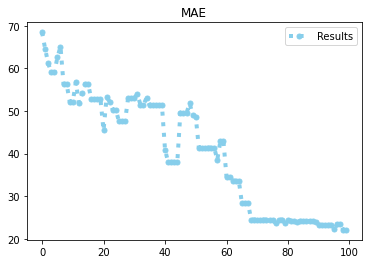

In [144]:
df=pd.DataFrame({'x_values': x_axis, 'Results': results})
plt.plot( 'x_values', 'Results', data=df, marker='o', markerfacecolor='skyblue', markersize=5, color='skyblue', linewidth=4, linestyle='dotted')
plt.title("MAE")
plt.legend()

Algorytm poradził sobie bardzo dobrze, udało się obniżyć *Mean absolute error* z 70 na 20, co jest dobrym wynikiem.

# Zbiór 3 

In [152]:
df = pd.read_csv('data/auto-mpg.csv', sep='\s+', header=None)
df = df[df[3] != "?"]
y = df.loc[:,0].to_numpy()
x = df.loc[:,1:7]
x = x.apply(pd.to_numeric).to_numpy()

In [110]:
layers = [7,10,12,1]
matrices = [layers[i]*layers[i+1] for i in range(len(layers)-1)]
mlp = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = False)

In [111]:
gen = genetic(mlp_score_regression, sum(matrices), 300)
results = []
x_axis = []
for i in range(100):
    mlp.weights = vector_to_weights(gen.optimum(),layers)
    results.append(mean_absolute_error(y, mlp.forward(x)))
    x_axis.append(i)
    gen.iterate(1)

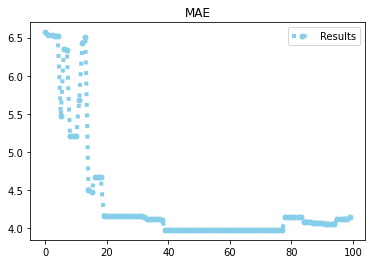

In [112]:
df=pd.DataFrame({'x_values': x_axis, 'Results': results})
plt.plot( 'x_values', 'Results', data=df, marker='o', markerfacecolor='skyblue', markersize=5, color='skyblue', linewidth=4, linestyle='dotted')
plt.title("MAE")
plt.legend()

Ponownie algorytm poradził sobie przyzwoicie, zmiejszając MAE prawie o połowę.